In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import numpy as np
import scipy.stats as stats
import pylab as pl

In [2]:
'''
filename
fifa_2018_results.csv
fifa_2018_results_updated_20180708.csv
fifa_2018_stats.csv
past_results.csv
players_scores.csv
sofifa.csv
'''

'\nfilename\nfifa_2018_results.csv\nfifa_2018_results_updated_20180708.csv\nfifa_2018_stats.csv\npast_results.csv\nplayers_scores.csv\nsofifa.csv\n'

In [3]:
#Preparing data
data = pd.read_csv('dataset/fifa_2018_results_updated_20180708.csv')
data.head()

data_home = data.groupby('home_team', as_index = False).agg({"home_result": np.sum})
data_away = data.groupby('away_team', as_index = False).agg({"away_result": np.sum})

data = data_home.rename( columns = {'home_team' : 'team'})
data['away_result'] = data_away['away_result']
data['total_score'] = data['away_result'] + data['home_result'] 

In [4]:
#Training Data
sofifa = pd.read_csv('dataset/sofifa1.csv') #only the latest stat
sofifa.rename(columns = {'countrystats' : 'team'} , inplace = True)
sofifa.head()

data_new = pd.read_csv('dataset/fifa_2018_results_updated_20180708.csv')
data1 = data_new.join(sofifa.set_index('team'), on = 'home_team')
data1 = data1.join(sofifa.add_suffix('_opponent').set_index('team_opponent'), on = 'away_team')
data1 = data1.drop(columns=['game','home_penalty','away_penalty','lat','long','stadium' ,'country','city','datestats','bu_positioning','cc_positioning','datestats_opponent','bu_positioning_opponent','cc_positioning_opponent'])
data_new = data1.dropna()

pd.options.display.max_rows = 200
# split train and test
y = np.array(list(zip(data_new['home_result'],data_new['away_result'])))
X = data_new.drop(columns = ['date','home_team','away_team','home_result','away_result'])
X = normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

#Prediction Data
fr = sofifa[sofifa['team'] == 'France'].drop(columns = ['datestats','bu_positioning','cc_positioning']).reset_index(drop=True)
cr = sofifa[sofifa['team'] == 'Croatia'].drop(columns = ['datestats','bu_positioning','cc_positioning']).reset_index(drop=True)

#France as home
data_predict = fr.join( cr.drop(columns = 'team').add_suffix('_opponent'))
#data_predict = data_predict.append(cr.join(fr.drop(columns = 'team').add_suffix('_opponent')), ignore_index = True)
data_predict.drop(columns ='team', inplace = True)
data_predict

(28, 24) (28, 2)
(8, 24) (8, 2)


,overall,attack,midfield,defense,bu_speed,bu_passing,cc_crossing,cc_passing,cc_shooting,aggression,...,midfield_opponent,defense_opponent,bu_speed_opponent,bu_passing_opponent,cc_crossing_opponent,cc_passing_opponent,cc_shooting_opponent,aggression_opponent,pressure_opponent,avg_age_opponent
0,84,83,85,82,35,30,53,24,35,47,...,78,74,59,44,74,39,61,61,61,26.64


In [5]:
team = np.array(data['team'])
home_s = np.array(data['home_result'])
away_s = np.array(data['away_result'])
total_s = np.array(data['total_score'])

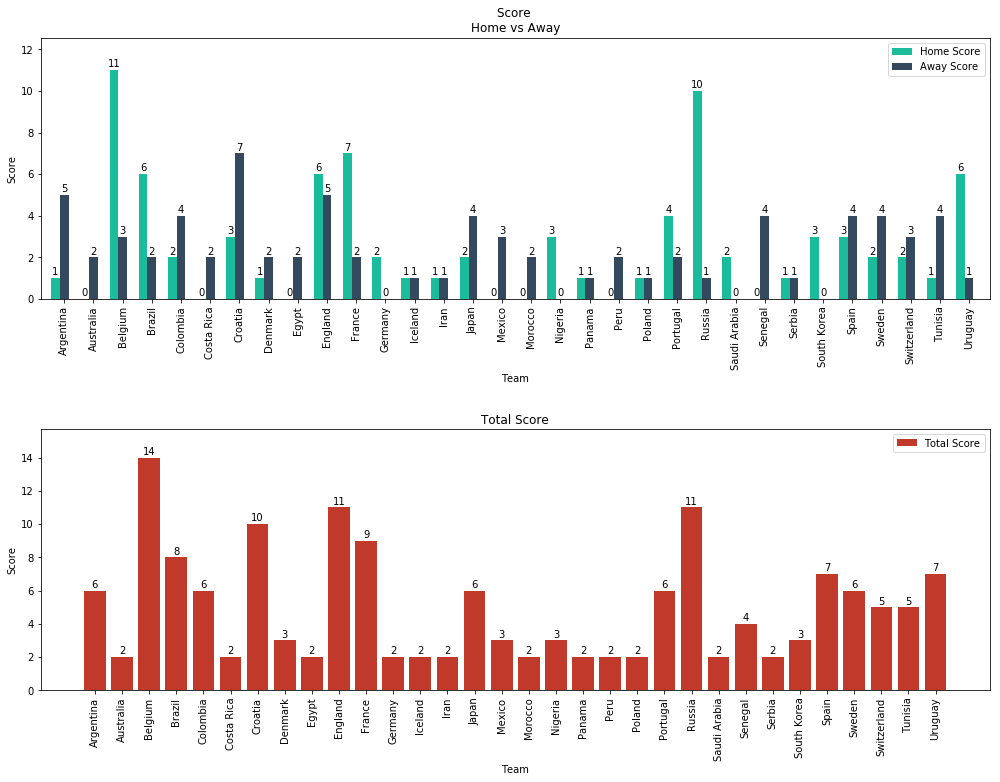

In [6]:
data['team'] = data['team'].astype('category')
index = data['team'].cat.codes
width = 0.3

fig , (ax ,axt) = plt.subplots(2, figsize=(17,12))
fig.subplots_adjust(hspace=.5)

home = ax.bar(index, home_s, width, label = 'Home Score', color = '#1abc9c')
away = ax.bar(index +width, away_s, width, label = 'Away Score', color ='#34495e')


def autolabel(bar):
    for b in bar:
        height = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, height+0.05, height, ha='center', va='bottom')
    
ax.set_xlim(left = min(index)-0.5 , right = max(index) + 1 )
ax.set_ylim(top = ax.get_ylim()[1] + 1)
ax.set_xticks(index + width) 
ax.set_xticklabels(team,  rotation='vertical')
ax.set_title('Score \nHome vs Away')
ax.set_xlabel('Team')
ax.set_ylabel('Score')
ax.legend()

autolabel(away)
autolabel(home)


total = axt.bar(data['team'], data['total_score'], label = 'Total Score' , color = '#c0392b')
axt.set_ylim(top = axt.get_ylim()[1] + 1)
axt.set_xticks(data['team']) 
axt.set_xticklabels(data['team'],  rotation='vertical')
axt.set_title('Total Score')
axt.set_xlabel('Team')
axt.set_ylabel('Score')
axt.legend()

for b in total:
    height = b.get_height()
    axt.text(b.get_x() +b.get_width()/2, height+0.05, height, ha='center', va='bottom')
    
plt.show()

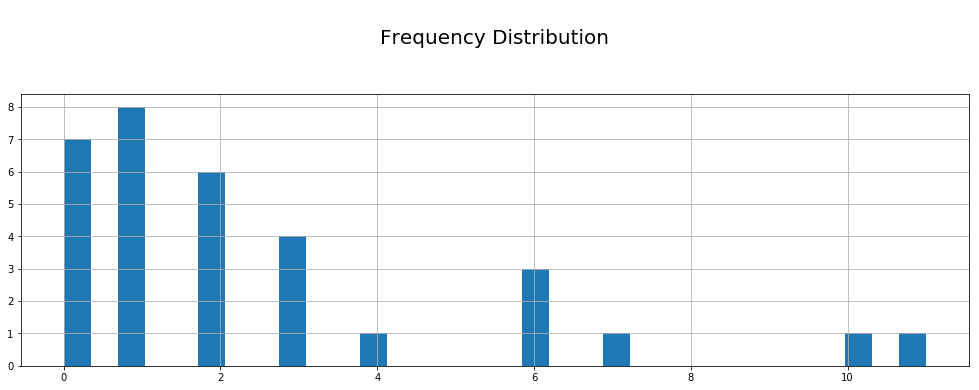

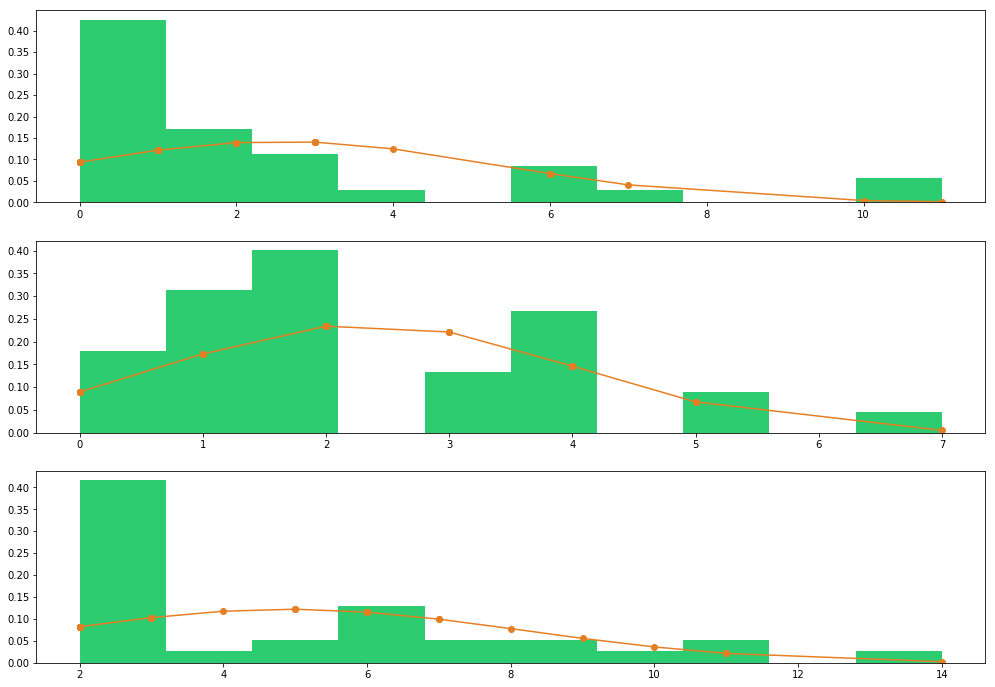

In [7]:
#Frequency Distribution 
sorted_home = np.sort(home_s)
sorted_away = np.sort(away_s)
sorted_total = np.sort(total_s)

plt.figure(figsize=(17,5))
plt.hist(sorted_home, bins = home_s.size)
plt.title('\nFrequency Distribution\n\n', fontsize= 20)
plt.grid(True)
plt.show()

fig , (fq1,fq2,fq3) = plt.subplots(3, figsize=(17,12))

def freq_dist(fq,dat):    
    fit = stats.norm.pdf(dat, np.mean(dat), np.std(dat)) 
    fq.plot(dat,fit,'-o' , color = '#e67e22')
    fq.hist(dat, density=True , color = '#2ecc71')
     
freq_dist(fq1,sorted_home)
freq_dist(fq2,sorted_away)
freq_dist(fq3,sorted_total)

plt.show() 

In [8]:
#Descriptive Analysis

#Mean | not skewed
home_mean = home_s.sum()/ home_s.size
away_mean = away_s.sum()/ away_s.size
total_mean = total_s.sum()/ total_s.size
print('Mean')
print(' Home : ' + str(home_mean))
print(' Away : ' + str(away_mean))
print(' Total : ' + str(total_mean))

#Median| skewed

#Mode
#Best measure of central tendency (nominal)
print('Mode')
print(' Home : ' + str(np.nanmax(home_s)))
print(' Away : ' + str(np.nanmax(away_s)))
print(' Total : ' + str(np.nanmax(total_s)))

Mean
 Home : 2.5625
 Away : 2.34375
 Total : 4.90625
Mode
 Home : 11
 Away : 7
 Total : 14


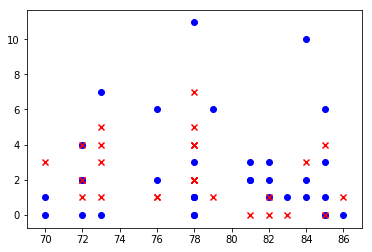

In [9]:
#Analyze Data Condition for model selection
overall = np.array(data_new['overall'])
overall_op = np.array(data_new['overall_opponent'])

for i in range (0,home_s.size):
    plt.scatter(overall[i],home_s[i], marker ='o', c ='b')
    plt.scatter(overall_op[i],away_s[i] , marker = 'x', c= 'r')
    
    
plt.show()



In [10]:
#Feature Extraction
from sklearn.decomposition import PCA, KernelPCA

def PCA_Transformer(PCA_data):    
    PCA_data = np.array(PCA_data)
    pca =PCA(n_components =24)
    pca.fit(PCA_data)
    #pca.fit_transform(PCA_data)
    X = pca.transform(PCA_data)
    print(pca.explained_variance_ratio_)
    print(pca.singular_values_)  
    print(X.size)
    
    return X


In [11]:
X_train = PCA_Transformer(X_train)


[2.85999099e-01 2.42108933e-01 1.07790084e-01 8.32181230e-02
 7.34180727e-02 5.85368033e-02 4.16616163e-02 3.57001173e-02
 2.43878961e-02 1.92449042e-02 1.24885731e-02 6.31203754e-03
 2.56866667e-03 1.99152283e-03 1.78078176e-03 1.44162662e-03
 4.28128584e-04 3.82752307e-04 3.13303966e-04 1.18135260e-04
 5.49932016e-05 4.14229100e-05 9.89450358e-06 2.51124535e-06]
[0.44104976 0.40579871 0.27076633 0.23791083 0.22346358 0.19953531
 0.16833457 0.15582606 0.12879305 0.11440978 0.09216407 0.06552244
 0.04179835 0.03680424 0.03480251 0.0313135  0.01706445 0.01613482
 0.01459783 0.00896386 0.00611589 0.00530793 0.00259419 0.00130692]
672


In [12]:
#Modelling
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier

clf1 = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
                   early_stopping=False, hidden_layer_sizes=(16, ), learning_rate='adaptive',
                   learning_rate_init=0.001, max_iter=10000, 
                   solver='lbfgs', tol=0.000001, verbose=True,
                   warm_start=False)

multi_target_mlp1 = MultiOutputClassifier(clf1 , n_jobs = -1)
multi_target_mlp1.fit(X_train, y_train)

clf2 =  MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
                     beta_1=0.1, beta_2=0.2, early_stopping=False,
                     epsilon=1e-08, hidden_layer_sizes=(16, ), learning_rate='adaptive',
                     learning_rate_init=0.001, max_iter=10000, shuffle=False,
                     solver='adam', tol=0.000001, verbose=True,
                     warm_start=False)
multi_target_mlp2 = MultiOutputClassifier(clf2 , n_jobs = -1)
multi_target_mlp2.fit(X_train, y_train)

clf3 = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       early_stopping=False,hidden_layer_sizes=(16, ), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.2,  shuffle=False,
       solver='sgd', tol=0.000001, verbose=True,
       warm_start=False)

multi_target_mlp3 = MultiOutputClassifier(clf3 , n_jobs = -1)
multi_target_mlp3.fit(X_train, y_train)

MultiOutputClassifier(estimator=MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(16,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.2, random_state=None,
       shuffle=False, solver='sgd', tol=1e-06, validation_fraction=0.1,
       verbose=True, warm_start=False),
           n_jobs=-1)

In [13]:
#Limited-memory Broyden–Fletcher–Goldfarb–Shanno (LFBGS)
score1 = multi_target_mlp1.predict(data_predict)
#Adam
score2 = multi_target_mlp2.predict(data_predict)
#Stochastic Gradient Descent
score3 = multi_target_mlp3.predict(data_predict)

In [14]:
print('\tFrance\tCroatia')
print('LBFGS\t   ' + str(score1[0][0])+ '\t   '+ str(score1[0][1]))
print('Adam\t   '+ str(score2[0][0])+ '\t   '+ str(score2[0][1]))
print('SGD\t   '+ str(score3[0][0])+ '\t   '+ str(score3[0][1]))

	France	Croatia
LBFGS	   0	   1
Adam	   0	   0
SGD	   4	   1


In [15]:
from sklearn.metrics import classification_report

#Accuracy 
acc1 = multi_target_mlp1.score(X_test,y_test)
acc2 = multi_target_mlp1.score(X_test,y_test)
acc3 = multi_target_mlp1.score(X_test,y_test)

total = y_test.size

In [16]:
print('LBFGS  : ' + str(acc1))
print('Adam   : ' + str(acc2))
print('SGD    : ' + str(acc3))

LBFGS  : 0.25
Adam   : 0.25
SGD    : 0.25
